#### Contact Info>
    Minji Lee
    email: lee.minji9521@gmail.com
    cell: 

#### Goal>>

    Transform the hourly wind speed using the power curve to get hourly energy production
    Aggregate hourly energy production to the monthly level
    Compare modeled monthly energy to the publicly reported observed energy

In [1]:
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
import nbconvert

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.interpolate import UnivariateSpline

In [3]:
%matplotlib inline

In [4]:
"""
windData = pd.read_csv("WindData.csv")
siteData = pd.read_csv("SiteData.csv")
powerCurve = pd.read_csv("PowerCurve.csv")
siteEnergy = pd.read_csv("SiteEnergy.csv")
"""


'\nwindData = pd.read_csv("WindData.csv")\nsiteData = pd.read_csv("SiteData.csv")\npowerCurve = pd.read_csv("PowerCurve.csv")\nsiteEnergy = pd.read_csv("SiteEnergy.csv")\n'

In [5]:
class Data: 
    # Object oriented approach

    def __init__(self,filepath):
        self.n = 0
        self.csv = pd.read_csv(filepath)
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        
        if self.n < len(self.csv)-1:
            self.n= self.n+1
            return self.csv.iloc[self.n]
        else:
            raise StopIteration
        
    def __str__(self):
        return str("This is a dataframe object\n\n" + str(self.csv.head()))
    
    # functions above are just basic functions
    
    def plot(self,x,y):
        
        fig = plt.figure()
        plt.plot(x,y)
        fig.suptitle('power curve', fontsize=15)
        plt.xlabel('wind speed')
        plt.ylabel('energy generated (kW)')
    
    def trainTestSplit(self, x, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.csv[x], self.csv[y],
                                                            test_size=0.33, random_state=12)
        
    def polynomialRegression(self, realData): 
        
        self.poly = PolynomialFeatures(degree = 15)
        # degree=15 means I want 15 different exponents. (x^0, x^1, x^2,...)
        
        X_train = np.array(self.X_train) 
        X_train = X_train.reshape(-1,1)
        X_train = self.poly.fit_transform(X_train)
        # X_train is local variable. I differentiated it from self.X_train to make self.X_train undisturbed\
        # in case it needed to be used in a different ML model.
       
        
        X_test = np.array(self.X_test)
        X_test = X_test.reshape(-1,1)
        X_test = self.poly.fit_transform(X_test)
        
        
        self.lm = LinearRegression()
        self.lm = Ridge(alpha=1.5)
        self.lm.fit(X_train, self.y_train)
        self.y_hat = self.lm.predict(X_test)
        
        self.lm.coef = self.lm.coef_ # linear regression coefficient
        
        X_poly = self.poly.fit_transform(np.array(realData['Wind_Speed']).reshape(-1,1)) # Apply the model to realData(windData)
        
        self.df_p = pd.DataFrame() # Make an empty dataframe
        self.df_p['p_energyPrediction'] = self.lm.predict(X_poly) # This is needed to compare the outcomes from polynomial regression to others
        
        
    def univariateSpline(self, realData):
        # goal is to make univariate Spline ML model
        
        X_train = np.array(self.X_train)
        X_train = X_train.reshape(-1,1)
        
        X_test = np.array(self.X_test)
        X_test = X_test.reshape(-1,1)
      
        s = UnivariateSpline(self.csv['WindSpeed.ms'].values, self.csv['Power.kW'].values, s=0)
        
        self.y_hat = s(self.X_test.values)
        
        self.df_s = pd.DataFrame()
        self.df_s['s_energyPrediction'] = s(realData.csv['Wind_Speed'])
        
        
        
    def rSquared(self): 
        # goal is to get the accuracy
        
        self.r_Squared = r2_score(np.array(self.y_test).reshape(-1,1), self.y_hat)
        print(self.r_Squared)

    def evaluationPlot(self):
        self.evaluation_plot = pd.DataFrame()
        
        self.evaluation_plot['wind_speed'] = self.X_test
        self.evaluation_plot['predicted energy (kW)'] = self.y_hat
        self.evaluation_plot['observed energy (kW)'] = self.y_test
        
        self.evaluation_plot.sort_values('wind_speed').set_index('wind_speed').plot(title='predicted energy vs observed energy (kW)')
        # plot and see if y_hat matches with y_test
        
    def comparisionDf(self, realData, siteEnergy): # realData here is windData
        # goal is to make a dataframe contains all the outcomes of different ML models and visualize them
        
        self.windData_compare = realData.csv.copy() # use windData to make groupby easier
        self.windData_compare['p_energyPrediction']= self.df_p['p_energyPrediction'] # add a new column
        self.windData_compare['s_energyPrediction']= self.df_s['s_energyPrediction'] # add a new column
        self.windData_compare['byMonth'] = pd.to_datetime(self.windData_compare['Time']).apply(lambda x: str(x.year) +'-' +str(x.month))
        # the code above is a preprocessing for groupby; only choose year and month
        
        self.windData_compare = self.windData_compare.groupby('byMonth').sum()
        # sum up the total generated energy by year and Month
        self.compareWithSite = pd.merge(self.windData_compare, siteEnergy.csv, left_on='byMonth',right_on='Month',how='inner')
        # merge windData_compare and siteEnergy. Put everything in 
        
        self.compareWithSite.plot(x='Month', title='Comparison of predicted energy and observed energy')
        # make a plot to see if our predictions match up with the siteEnergy

In [6]:
windData = Data(filepath ="/windData.csv")
siteData = Data(filepath ="/siteData.csv")
powerCurve = Data(filepath ="/PowerCurve.csv")
siteEnergy = Data(filepath ="/siteEnergy.csv")

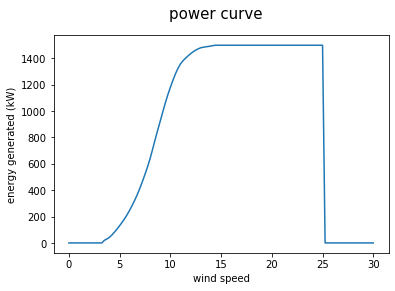

In [7]:
powerCurve.plot(powerCurve.csv['WindSpeed.ms'], powerCurve.csv['Power.kW'])

In [8]:
powerCurve.trainTestSplit('WindSpeed.ms','Power.kW')

### Polynomial

In [9]:
powerCurve.polynomialRegression(windData.csv)

c:\users\minji\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.99917e-45): result may not be accurate.
  overwrite_a=True).T


In [10]:
powerCurve.rSquared()

0.8979215815360578


    89% is a fine accuracy

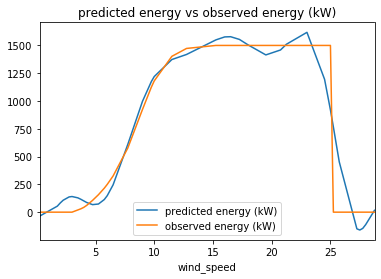

In [11]:
powerCurve.evaluationPlot()

    The polynomial regression cannot catch all. Let's make it better

### UivariateSpline

In [12]:
powerCurve.trainTestSplit('WindSpeed.ms','Power.kW')

In [13]:
powerCurve.univariateSpline(windData)

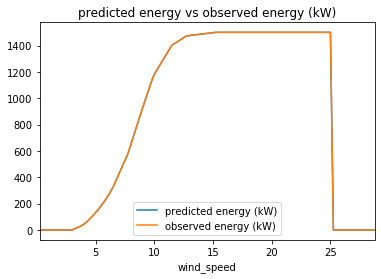

In [14]:
powerCurve.evaluationPlot()

    The plot looks way better.

In [15]:
powerCurve.rSquared()

1.0


    100% accuracy!

### Compare them to the siteEnergy

    Let's see how well does univarateSpline and polynomial regression do and compare to the siteEnergy

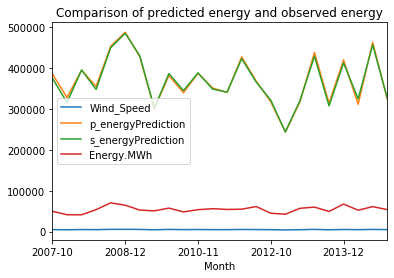

In [16]:
powerCurve.comparisionDf(windData, siteEnergy)

        Model accuracies were 89% for polynomial regression and 100% for univariate spline.
        
        Based on the p_powerPrediction(power prediction by polynomial regression) and s_powerPrediction (power prediction by univariateSpline) the energy from siteEnergy.csv is way less than what I predicted from polynomial model and spline model. Therefore I concluded that met data is not suitable to predict energy output at the site. 
        
        My hypothesis are that 1. there are a lot of wind that did not go into the power generator 2. Maybe the windData is not accurately recorded because the location where the wind recording machine gets wind blows all of sudden when the machine records the windspeed and stops all of sudden when the machine is not recording, and that contributed unaccurate record of wind